In [144]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
#expor
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup
### Data

In [146]:
mpl.rcParams['image.cmap'] = 'gray'

In [147]:
x_train, y_train, x_valid, y_valid = get_data()

In [148]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [149]:
class Model(nn.Module):
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [150]:
model = Model(m, nh, c.item())

In [151]:
pred = model(x_train)

## Cross entropy loss
\begin{equation}\operatorname{softmax}(x)_i=\frac{e^{x_i}}{\sum_j e^{x_j}}\end{equation}

*The `keepdim=True` so that the sum can be broadcasted along the `x.exp()` tensor.*

In [152]:
def log_softmax(x):
    return (x.exp()/(x.exp().sum(dim=-1, keepdim=True))).log()

In [153]:
sm_pred = log_softmax(pred)

The cross entropy loss is given by 
\begin{equation}-\sum x\log p(x)
\end{equation}
where $x$ is the target and $p(x)$ the prediction. As our targets are one-hot encoded, this can be rewritten as $-\log p_i$. How can we express this in a nice way in PyTorch? We use numpy-style *integer array indexing*.

In [154]:
y_train[:5]

tensor([5, 0, 4, 1, 9])

What are our predictions associated with *5, 0, 4, 1, 9*?

In [155]:
sm_pred[0][5], sm_pred[1][0], sm_pred[2][4], sm_pred[3][1], sm_pred[4][9]

(tensor(-2.3018, grad_fn=<SelectBackward>),
 tensor(-2.4170, grad_fn=<SelectBackward>),
 tensor(-2.2576, grad_fn=<SelectBackward>),
 tensor(-2.2584, grad_fn=<SelectBackward>),
 tensor(-2.3295, grad_fn=<SelectBackward>))

In [156]:
sm_pred[[0,1,2,3,4], [5, 0, 4, 1, 9]]

tensor([-2.3018, -2.4170, -2.2576, -2.2584, -2.3295], grad_fn=<IndexBackward>)

or

In [157]:
sm_pred[range(5), y_train[:5]]

tensor([-2.3018, -2.4170, -2.2576, -2.2584, -2.3295], grad_fn=<IndexBackward>)

In [158]:
y_train.shape[0]

50000

In [159]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [160]:
loss = nll(sm_pred, y_train)

In [161]:
loss

tensor(2.3055, grad_fn=<NegBackward>)

We can rewrite the loss using $\log(a/b)=\log(a)-\log(b)$:

In [162]:
def log_softmax(x):
    return x - (x.exp().sum(dim=-1, keepdim=True)).log()

In [163]:
test_near(loss, nll(log_softmax(pred), y_train))

However, we would like to find a way to calculate the nll loss in a more stable way because the sum of the exponentials can get very large and overflow when taking the exp of a big activation. We use the so-called LogSumExp trick:

\begin{equation}
\log\left(\sum_{j=1}^ne^{x_j}\right)=\log\left(e^a\sum_{j=1}^ne^{x_j - a}\right) =a+ \log\left(\sum_{j=1}^ne^{x_j-a}\right)
\end{equation}

For $a$ we use the maximum of all $x_j$.

In [164]:
def logSumExp(x):
    a = x.max(dim=-1)[0]  # The shape of pred is torch.Size([50000, 10]) and [0] to get the values (not indxs)
    return a + (x-a.unsqueeze(-1)).exp().sum(dim=-1).log()  # The .unsqueeze so that a can be broadcasted

In [165]:
logSumExp(pred)

tensor([2.3006, 2.3079, 2.2543,  ..., 2.2578, 2.3063, 2.3116],
       grad_fn=<AddBackward0>)

*In PyTorch this is already implemented for us!*

In [166]:
test_near(logSumExp(pred), pred.logsumexp(-1))

In [167]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [168]:
test_near(nll(log_softmax(pred), y_train), loss)

Now we can also use PyTorch's implementation:

In [169]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

PyTorch combines `F.log_softmax` and `nll_loss` into one optimized function called `F.cross_entropy`:

In [170]:
test_near(F.cross_entropy(pred, y_train), loss)

# Basic training loop

In [171]:
loss_func = F.cross_entropy

In [172]:
#export
def accuracy(pred, targ):
    return (torch.argmax(pred, dim=-1)==targ).float().mean()

In [173]:
bs = 64                   # batch size
x_batch  = x_train[:bs]   # a mini-batch
preds = model(x_batch)
preds[0], preds.shape

(tensor([-0.2583,  0.1005, -0.1978,  0.0175,  0.0780, -0.0012, -0.0792,  0.1039,
          0.0746,  0.0704], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [174]:
accuracy(preds, y_train[:bs])

tensor(0.0781)

In [175]:
loss_func(preds, y_train[:bs])

tensor(2.3117, grad_fn=<NllLossBackward>)

In [176]:
lr = 0.5
epochs = 1

In [177]:
for epoch in range(epochs):
    for i in range((n-1)//bs):
        
        start_idx = i * bs
        end_idx = start_idx + bs
        x_batch = x_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]
        
        loss = loss_func(model(x_batch), y_batch)
        
        loss.backward()
        with torch.no_grad():  # Not part of the gradient calculation but the result of it
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [178]:
loss_func(model(x_valid), y_valid)

tensor(0.1748, grad_fn=<NllLossBackward>)

In [179]:
accuracy(model(x_valid), y_valid)

tensor(0.9489)

**Let's make this less messy!**

## Introduce parameters
We use `nn.Module.__setattr__` and move the relu to functional:

In [180]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [181]:
model = Model(m, nh, 10)

In [182]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [183]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [184]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [185]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs):
            
            start_idx = i * bs
            end_idx = start_idx + bs
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            loss = loss_func(model(x_batch), y_batch)
            
            loss.backward()
            with torch.no_grad():  # Not part of the gradient calculation but the result of it
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [186]:
fit()

In [187]:
loss_func(model(x_valid), y_valid)

tensor(0.1891, grad_fn=<NllLossBackward>)

In [188]:
accuracy(model(x_valid), y_valid)

tensor(0.9423)

**How does this work behind the scenes?**

In [189]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [190]:
mdl = DummyModule(m, nh, 10)

In [191]:
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [192]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [193]:
mdl.__getattribute__("l1")

Linear(in_features=784, out_features=50, bias=True)

**What do we do if we want to pass a list of Layers to the constructor instead of defining them individually with `self.`?**

In [194]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [195]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(layers):
            self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [196]:
nn.Module.add_module??

**Summary: checks if `l` has a compatible type and then does `self._modules[name] = module`, just as we did!**

In [197]:
model = Model(layers)

In [198]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [199]:
nn.Module.__repr__??

**`nn.ModuleList` does exactly that for us!**

In [200]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x  

In [201]:
model = SequentialModel(layers)

In [202]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [203]:
fit()

In [204]:
loss_func(model(x_valid), y_valid)

tensor(0.1788, grad_fn=<NllLossBackward>)

In [205]:
accuracy(model(x_valid), y_valid)

tensor(0.9463)

**`nn.Sequential` does the exact same thing very conveniently four us:**

In [206]:
model = nn.Sequential(*layers)

In [207]:
fit()

In [208]:
loss_func(model(x_valid), y_valid)

tensor(0.1447, grad_fn=<NllLossBackward>)

In [209]:
accuracy(model(x_valid), y_valid)

tensor(0.9567)

In [210]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [211]:
nn.Sequential??

## Introduce optimizers
Whe would like to replace the lines

```
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
        model.zero_grad()
```

with something like this:

```
opt.step()
opt.zero_grad()
```

Also note that it is important that we change from `model.zero_grad()` to `opt.zero_grad()` as we might want to ask our optimizer to take care of only *part* of the model's parameters, i.e. when gradually unfreezing.

In [212]:
class Optimizer():
    def __init__(self, parameters, lr=0.5):
        self.parameters = parameters
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p -= p.grad * lr
    
    def zero_grad(self):
        for p in self.parameters:
            p.grad.data.zero_()

In [213]:
model = nn.Sequential(*layers)

In [214]:
opt = Optimizer(model.parameters())

In [215]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs):
            
            start_idx = i * bs
            end_idx = start_idx + bs
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            loss = loss_func(model(x_batch), y_batch)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [216]:
fit()

In [217]:
loss_func(model(x_valid), y_valid)

tensor(0.1319, grad_fn=<NllLossBackward>)

In [218]:
accuracy(model(x_valid), y_valid)

tensor(0.9598)

**Of course PyTorch already provides this functionality!**

In [219]:
#export
from torch import optim

In [220]:
optim.SGD.step??

PyTorch's `optim.SGD` applies the updates for each layer group at a time:

```
for group in self.param_groups:
    weight_decay = group['weight_decay']
    momentum = group['momentum']
    dampening = group['dampening']
    nesterov = group['nesterov']
    
    # ...
    for p in group['params']:
       d_p = p.grad.data
       # ...
       p.data.add_(-group['lr'], d_p)
```

In [221]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [222]:
model, opt = get_model()

In [223]:
loss_func(model(x_valid), y_valid)

tensor(2.3069, grad_fn=<NllLossBackward>)

In [224]:
fit()

In [225]:
loss_func(model(x_valid), y_valid)

tensor(0.1558, grad_fn=<NllLossBackward>)

In [226]:
acc = accuracy(model(x_valid), y_valid); acc

tensor(0.9565)

In [227]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

Let's go from

```
x_batch = x_train[start_idx:end_idx]
y_batch = y_train[start_idx:end_idx]
```

to: 

```
x_batch, y_batch = train_ds[i*bs : i*bs + bs]
```

In [228]:
#export
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
        assert len(self.x) == len(self.y)
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [229]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [230]:
assert len(train_ds) == len(x_train)

In [231]:
xb, yb = train_ds[0:5]
assert xb.shape == (5,28*28)
assert yb.shape == (5,)

In [232]:
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

### Dataloader

Let's go from
```
for i in range((n-1)//bs):
   x_batch, y_batch = train_ds[i*bs : i*bs + bs]
```

to:

```
xb, yb in train_dl:
   ...
```

In [233]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i : i + bs]

In [234]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [235]:
xb, yb = next(iter(train_dl))

In [236]:
assert xb.shape == (bs, 28*28)
assert yb.shape == (bs,)

tensor(5)

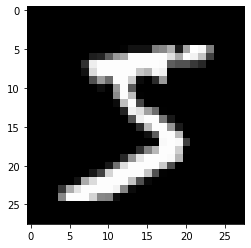

In [237]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [238]:
model, opt = get_model()

In [239]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

**This is pretty beautiful now, isn't it?? :D**

In [240]:
fit()

In [241]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1319, grad_fn=<NllLossBackward>), tensor(0.9531))

## Random sampling
We aim to train in a more random order. This order should differ each epoch. The validation set should not be shuffled.

In [242]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs):
            yield self.idxs[i : i+self.bs]

In [243]:
small_ds = Dataset(*train_ds[:10])

In [244]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [245]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([9, 1, 5]), tensor([0, 3, 7]), tensor([8, 4, 2]), tensor([6])]

In [246]:
def collate(b):
    xs, ys = zip(*b)  # list of tuples -> two lists
    return torch.stack(xs), torch.stack(ys)

In [247]:
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler:  # gives us batches of indices at a time
            yield self.collate_fn([self.ds[i] for i in s])  # gives a list of (x,y) tuples

In [248]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [249]:
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(valid_ds, valid_samp)

tensor(0)

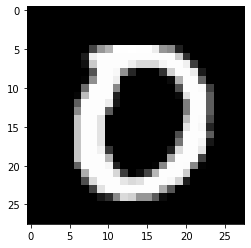

In [250]:
# In random order
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

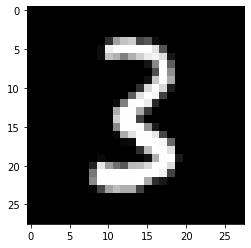

In [251]:
# Always same order
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [252]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(x_valid), y_valid), accuracy(model(x_valid), y_valid)
assert acc > 0.7
loss, acc

(tensor(0.1805, grad_fn=<NllLossBackward>), tensor(0.9459))

## PyTorch DataLoader

In [253]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [254]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [255]:
model, opt = get_model()
fit()
loss_func(model(x_valid), y_valid), accuracy(model(x_valid), y_valid)

(tensor(0.1524, grad_fn=<NllLossBackward>), tensor(0.9549))

Often, a custom sampler is not even necessary:

In [256]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

PyTorch's `DataLoader` takes the additional argument `num_workers`. Will use multiple threads to call your `Dataset`. Very useful when opening large images and applying many transformations.

## Validation

In [257]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()  # To handle batchnorm / dropout
        
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [258]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [262]:
model, opt = get_model()
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)

In [263]:
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1801) tensor(0.9438)
1 tensor(0.5303) tensor(0.8694)
2 tensor(0.1191) tensor(0.9674)
3 tensor(0.1221) tensor(0.9666)
4 tensor(0.3048) tensor(0.9144)


In [264]:
assert acc > 0.9

### Export

In [265]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
